In [8]:
from datasets import load_dataset
from tensorflow import keras
import time
import json
import pandas as pd
import glob
import pdb
import numpy as np
import tensorflow as tf
import os

In [43]:
mig_path = '../models/logs/mig'
mig_slices = ['7g.40gb', '4g.20gb', '3g.20gb']
target = '2g.10gb'

In [61]:
record = glob.glob(f'{mig_path}/{target}*.json')
y = []
x = []
for path in record:
    with open(path) as f:
        lat = json.load(f)
    mean_lat = []
    for key, val in lat.items():
        mean_lat += val
    mean_lat = mean_lat[1:] # remove 1st element
    mean_lat = round(np.mean(mean_lat),4)
    y.append(1/mean_lat)
    data = []
    for mig in mig_slices:
        new_path = path.replace(target, mig)
        with open(new_path) as f:
            lat = json.load(f)
        mean_lat = []
        for key, val in lat.items():
            mean_lat += val
        mean_lat = mean_lat[1:] # remove 1st element
        mean_lat = round(np.mean(mean_lat),4)
        data.append(1/mean_lat)
    x.append(data)
new_x = []
for i in range(len(y)):
    y[i] = y[i] / x[i][0]
    new_x.append(np.array(x[i]) / x[i][0])

new_x,y

([array([1.        , 0.68704512, 0.62682603]),
  array([1.        , 0.72794118, 0.63461538]),
  array([1.        , 0.91891892, 0.89473684]),
  array([1.        , 0.88888889, 1.        ]),
  array([1.        , 0.79883319, 0.62386095]),
  array([1.        , 0.86630404, 0.75049603]),
  array([1.        , 0.79770366, 0.67948957]),
  array([1.        , 0.71794872, 0.66666667]),
  array([1.        , 0.61946903, 0.56300268]),
  array([1.        , 0.69507324, 0.61775148]),
  array([1.        , 0.81632653, 0.75471698]),
  array([1.        , 0.7414844 , 0.59468009]),
  array([1.        , 0.7795874 , 0.71728272]),
  array([1.        , 0.9609375 , 0.93181818]),
  array([1.        , 0.58719441, 0.48885443]),
  array([1.        , 0.61572052, 0.55599369]),
  array([1.        , 0.7484787 , 0.65309735]),
  array([1.        , 0.92690058, 0.85215054]),
  array([1.        , 0.83687943, 0.77124183]),
  array([1.        , 0.59516129, 0.53478261]),
  array([1.        , 0.96451613, 0.93730408]),
  array([1.  

In [62]:
y[2], x[2]

(0.7083333333333334,
 [294.11764705882354, 270.27027027027026, 263.1578947368421])

In [65]:
from sklearn.linear_model import LinearRegression
import sklearn
reg = LinearRegression().fit(new_x, y)
reg.score(new_x,y)

pred_y = reg.predict(new_x)
reg.score(new_x,y), sklearn.metrics.mean_absolute_error(y, pred_y)

(0.9625953728654644, 0.030028613742393895)

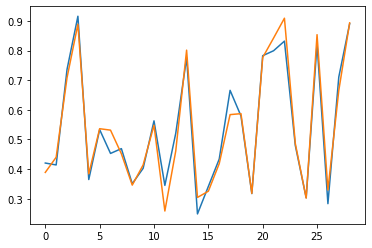

In [66]:
import matplotlib.pyplot as plt
plt.plot(pred_y)
plt.plot(y)
# plt.plot(y-pred_y)

In [39]:
list(pred_y), list(y)

([0.10366902047526994,
  0.08644958854786278,
  0.02763433019912045,
  0.025901161665431945,
  1.1452825382853864,
  0.49670406663024247,
  1.4784929612165185,
  0.03385694384753031,
  0.06868549685125241,
  0.12712717354893488,
  0.030711206104614287,
  1.2698107884325291,
  0.19809962753719557,
  0.033333188145848264,
  0.9159651929231338,
  0.1757163516592135,
  0.09722919392751217,
  0.05217096734163773,
  0.03847672746708154,
  0.11162678067485277,
  0.03407837343048359,
  0.026734361212168746,
  0.027941256789688257,
  0.049812220213615616,
  0.1898402833487728,
  0.028804806081977302,
  0.6279936709250502,
  0.04452834710026238,
  0.0164233754168166],
 [0.1214,
  0.0675,
  0.0048,
  0.0009,
  0.963,
  0.5643,
  1.3727,
  0.0124,
  0.0607,
  0.1261,
  0.0073,
  1.5997,
  0.3116,
  0.0307,
  0.8286,
  0.2167,
  0.0882,
  0.0543,
  0.0201,
  0.1161,
  0.0385,
  0.0038,
  0.0209,
  0.0368,
  0.2264,
  0.0239,
  0.5666,
  0.0472,
  0.0319])

In [3]:
target_data = []
input_data = []

for i in range(1, active_range+1):
    for j in range(repeat_range):
        record = glob.glob(f'{input_dir}/active{i}_repeat{j}_*.csv')[0]
        data = pd.read_csv(record, header=None).to_numpy()
        
        ########### freature data ############
        norm_data = np.zeros(data.shape)
        for col in range(data.shape[1]):            
            norm_data[:,col] = np.round(data[:,col] / data[:,col].max(), 4)
        input_data.append(norm_data)
        
        ########### create label data ###########
        label_data = np.zeros(data.shape)
        model_str = record.split(f'_repeat{j}_')[1].split('.')[0]
        for col in range(data.shape[1]):
            model = glob.glob(f'{label_path}/active{i}_repeat{j}/{model_str}{col}_100pct*.json')[0]
            model = model.split('_100pct_')[1].split('.')[0] # mobilenet_train64
            
            slice_time = []
            for mig_slice in mig_slices:
                filename = f'{mig_path}/{mig_slice}_{model}.json'
#                 if os.path.isfile(filename):
                with open(filename) as f:
                    lat = json.load(f)
                mean_lat = []
                for key, val in lat.items():
                    mean_lat += val
                mean_lat = mean_lat[1:] # remove 1st element
                mean_lat = round(np.mean(mean_lat),4)
                slice_time.append(mean_lat)
            slice_time = np.asarray(slice_time)            
            slice_time = np.round(slice_time / slice_time.max(),4)            
            label_data[:,col] = slice_time
        target_data.append(label_data)                    
        
        for shuffle in range(shuffle_time):
            new_index = np.random.permutation(norm_data.shape[1])
            input_data.append(norm_data[:, new_index])
            target_data.append(label_data[:, new_index])
        
input_data = np.asarray(input_data)
target_data = np.asarray(target_data)

In [5]:
input_data.shape, target_data.shape

((14000, 3, 7), (14000, 3, 7))

In [6]:
if os.path.isfile('input_data.npy'):
    os.remove('input_data.npy')
if os.path.isfile('target_data.npy'):
    os.remove('target_data.npy')
np.save('input_data.npy', input_data)
np.save('target_data.npy', target_data)

In [7]:
load = np.load('input_data.npy')
load.min(), load.max()


(0.0879, 1.0)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((input_data,target_data))

2022-02-22 16:50:01.482277: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-22 16:50:02.019425: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10801 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:05:00.0, compute capability: 3.7


In [9]:
train_dataset

<TensorSliceDataset shapes: ((3, 7), (3, 7)), types: (tf.float64, tf.float64)>

In [10]:
train_dataset.shuffle(100).batch(8)
train_dataset

<TensorSliceDataset shapes: ((3, 7), (3, 7)), types: (tf.float64, tf.float64)>

In [11]:
tf.data.experimental.cardinality(train_dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=14000>